#Vivek Golla
##HDS 5230-07
##Week 05 Assignment - Dask Programming Assignment

In [2]:
#install dask distributed package to use distributed scheduler
!pip install dask distributed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.10.0
    Uninstalling dask-2024.10.0:
      Successfully uninstalled dask-2024.10.0


In [3]:
import dask.dataframe as dd
import datetime as dt
import pandas as pd
import numpy as np

In [4]:
#set up the client - i have 8 cores on my machine
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=2)
client = Client(cluster)
print(client)


INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:41643
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37417'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39695'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36481'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39439'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:41163 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:41163
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:32780
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:39009 name: 2
INFO:

<Client: 'tcp://127.0.0.1:41643' processes=4 threads=8, memory=12.67 GiB>


##QUESTION 2

In [6]:
#loading the timeseries data  into a dask dataframe object
import datetime as dt
timeseries_pd = pd.read_csv("timeseries.csv", dtype={'name':str,'level':str,'city':object,'county':str,'state':str,'country':str,'population':np.float64,'lat':float,'long':float,'url':str,'aggregate':object,'tz':str,'cases':np.float64,'deaths':np.float64,'recovered':np.float64,'active':np.float64,'tested':np.float64,'hospitalized':np.float64,'hospitalized_current':np.float64,'discharged':np.float64,'icu':np.float64,'icu_current':np.float64,'growthFactor':np.float64,'date':str})
df = dd.from_pandas(timeseries_pd, npartitions=10)
df['date'] = dd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

/usr/local/lib/python3.11/dist-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 143.88 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


,name,level,city,county,state,country,population,lat,long,url,...,deaths,recovered,active,tested,hospitalized,hospitalized_current,discharged,icu,icu_current,growthFactor
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,"Antwerp, Flanders, Belgium",county,<NA>,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-22,"Namur, Wallonia, Belgium",county,<NA>,Namur,Wallonia,Belgium,493073.0,50.2170,4.8410,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-22,"Hainaut, Wallonia, Belgium",county,<NA>,Hainaut,Wallonia,Belgium,1341645.0,50.3765,3.7270,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-22,"Brussels-Capital, Brussels-Capital, Belgium",county,<NA>,Brussels-Capital,Brussels-Capital,Belgium,1198726.0,50.8415,4.3625,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-22,"Brussels-Capital, Belgium",state,<NA>,<NA>,Brussels-Capital,Belgium,1198726.0,50.8415,4.3625,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##QUESTION 3.1

In [7]:
#now filtering by USA and grouping by the states to get new filtered dataset
def filter_df(df):
  filtered_df = df.query("country == 'United States'").persist()
  filtered_df = filtered_df[filtered_df['state'] != '<NA>'].copy()
  return filtered_df

/usr/local/lib/python3.11/dist-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 143.91 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 143.89 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


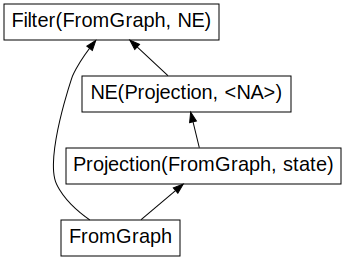

In [8]:
filter_ddf = filter_df(df)
filter_ddf.visualize(filename='filter_graph.png')

In [9]:
#time and compute filtered dataframe
#%%timeit
filtered_df = filter_df(df)
filtered_df.compute()

/usr/local/lib/python3.11/dist-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 143.89 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


,name,level,city,county,state,country,population,lat,long,url,...,deaths,recovered,active,tested,hospitalized,hospitalized_current,discharged,icu,icu_current,growthFactor
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,"Washington, United States",state,<NA>,<NA>,Washington,United States,7614893.0,47.2730,-120.8245,https://covidtracking.com/api/v1/states/curren...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-22,"King County, Washington, United States",county,<NA>,King County,Washington,United States,2252782.0,47.4330,-121.7970,https://services8.arcgis.com/rGGrs6HCnw87OFOT/...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-22,"Snohomish County, Washington, United States",county,<NA>,Snohomish County,Washington,United States,822083.0,48.0370,-121.6585,https://services8.arcgis.com/rGGrs6HCnw87OFOT/...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,"Snohomish County, Washington, United States",county,<NA>,Snohomish County,Washington,United States,822083.0,48.0370,-121.6585,https://services8.arcgis.com/rGGrs6HCnw87OFOT/...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-01-23,"Washington, United States",state,<NA>,<NA>,Washington,United States,7614893.0,47.2730,-120.8245,https://covidtracking.com/api/v1/states/curren...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-05,"Independence County, Arkansas, United States",county,<NA>,Independence County,Arkansas,United States,37825.0,35.7345,-91.5350,https://services.arcgis.com/PwY9ZuZRDiI5nXUB/A...,...,NaN,52.0,8.0,3082.0,NaN,NaN,NaN,NaN,NaN,1.0
2020-07-05,"Schenectady County, New York, United States",county,<NA>,Schenectady County,New York,United States,155299.0,42.8340,-74.0570,https://raw.githubusercontent.com/nytimes/covi...,...,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-07-05,"Schoharie County, New York, United States",county,<NA>,Schoharie County,New York,United States,30999.0,42.5925,-74.4385,https://raw.githubusercontent.com/nytimes/covi...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


###Reasoning
Filtering (using operations like .query() and slicing with .loc) is an “embarrassingly parallel” operation because each partition can independently apply the filter without needing to communicate with others.

In [10]:
#get new dataframe based on date range 2020-01-01 to 2021-02-28
def date_filter(filtered_df):
  new_df = filtered_df.loc[dt.date(year=2020,month=1,day=1):dt.date(year=2021,month=2,day=28)].reset_index()

  return new_df

In [11]:
new_df = date_filter(filtered_df)
new_df.compute()

,date,name,level,city,county,state,country,population,lat,long,...,deaths,recovered,active,tested,hospitalized,hospitalized_current,discharged,icu,icu_current,growthFactor
0,2020-01-22,"Washington, United States",state,<NA>,<NA>,Washington,United States,7614893.0,47.2730,-120.8245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-22,"King County, Washington, United States",county,<NA>,King County,Washington,United States,2252782.0,47.4330,-121.7970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-22,"Snohomish County, Washington, United States",county,<NA>,Snohomish County,Washington,United States,822083.0,48.0370,-121.6585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-23,"Snohomish County, Washington, United States",county,<NA>,Snohomish County,Washington,United States,822083.0,48.0370,-121.6585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,2020-01-23,"Washington, United States",state,<NA>,<NA>,Washington,United States,7614893.0,47.2730,-120.8245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34129,2020-07-05,"Independence County, Arkansas, United States",county,<NA>,Independence County,Arkansas,United States,37825.0,35.7345,-91.5350,...,NaN,52.0,8.0,3082.0,NaN,NaN,NaN,NaN,NaN,1.0
34130,2020-07-05,"Schenectady County, New York, United States",county,<NA>,Schenectady County,New York,United States,155299.0,42.8340,-74.0570,...,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
34131,2020-07-05,"Schoharie County, New York, United States",county,<NA>,Schoharie County,New York,United States,30999.0,42.5925,-74.4385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
34132,2020-07-05,"Schuyler County, New York, United States",county,<NA>,Schuyler County,New York,United States,17807.0,42.3905,-76.8630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


##QUESTION 3.2

In [12]:
#defining the function to calculate mortality rate
def compute_mortality(filtered_df):
  #calculate mortality rate
  mortality_rate = (new_df.groupby('state')['deaths'].sum() /
                      new_df.groupby('state')['population'].mean()).reset_index()

  mortality_rate = mortality_rate.rename(columns={0: 'mortality_rate'})
  #sorting mortality rate - ranking states
  mortality_rate = mortality_rate.sort_values(by='mortality_rate', ascending=False)
  return mortality_rate

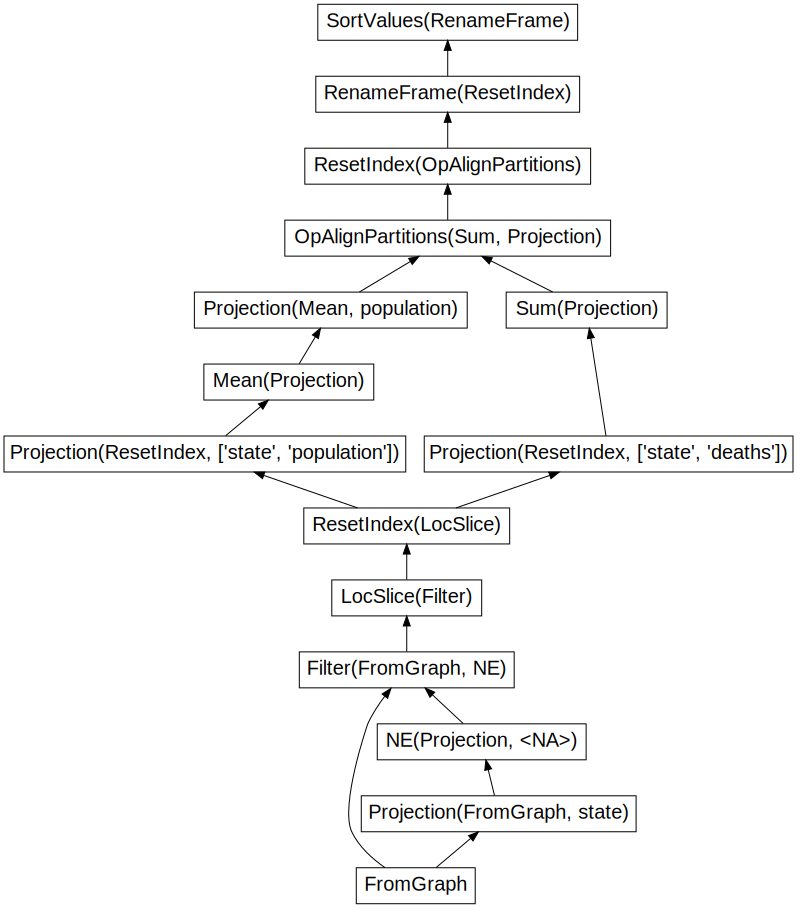

In [13]:
#graph and visualization of mortality rate function
mortality_ddf = compute_mortality(filtered_df)
mortality_ddf.visualize(filename='mortality_graph.png')

In [14]:
#time and compute mortality rate ranking
#%%timeit
result = compute_mortality(filtered_df)
result.compute()

,state,mortality_rate
32,New York,6.395701
22,Michigan,3.204753
18,Louisiana,2.735288
13,Illinois,2.043863
30,New Jersey,2.031200
9,Georgia,2.026085
38,Pennsylvania,1.831572
46,Virginia,1.359063
24,Mississippi,1.356705
14,Indiana,1.353423


###Reasoning
Calculating mortality rates involves grouping by state and then aggregating (summing deaths and averaging populations). These operations are naturally parallelizable because groupby operations can be computed on different partitions and then combined.

##QUESTION 3.3

In [41]:
#function to compute the CFR (case fatality ratio)
def compute_cfr(filtered_df):
  #calculate case fatality ratio
  new_df['month'] = new_df['date'].dt.month.astype(str) + ' ' + new_df['date'].dt.year.astype(str)

  cfr = (new_df.groupby(['state','month'])['deaths'].sum() /
                      new_df.groupby(['state','month'])['cases'].sum()).reset_index()
  cfr = cfr.rename(columns={0: 'Case Fatality Ratio'})

  cfr['month'] = cfr['month'].astype('category')
  cfr['month'] = cfr['month'].cat.as_known()

  # Convert to wide format using pivot_table
  cfr_wide = cfr.pivot_table(index='state', columns='month', values='Case Fatality Ratio')

  return cfr_wide

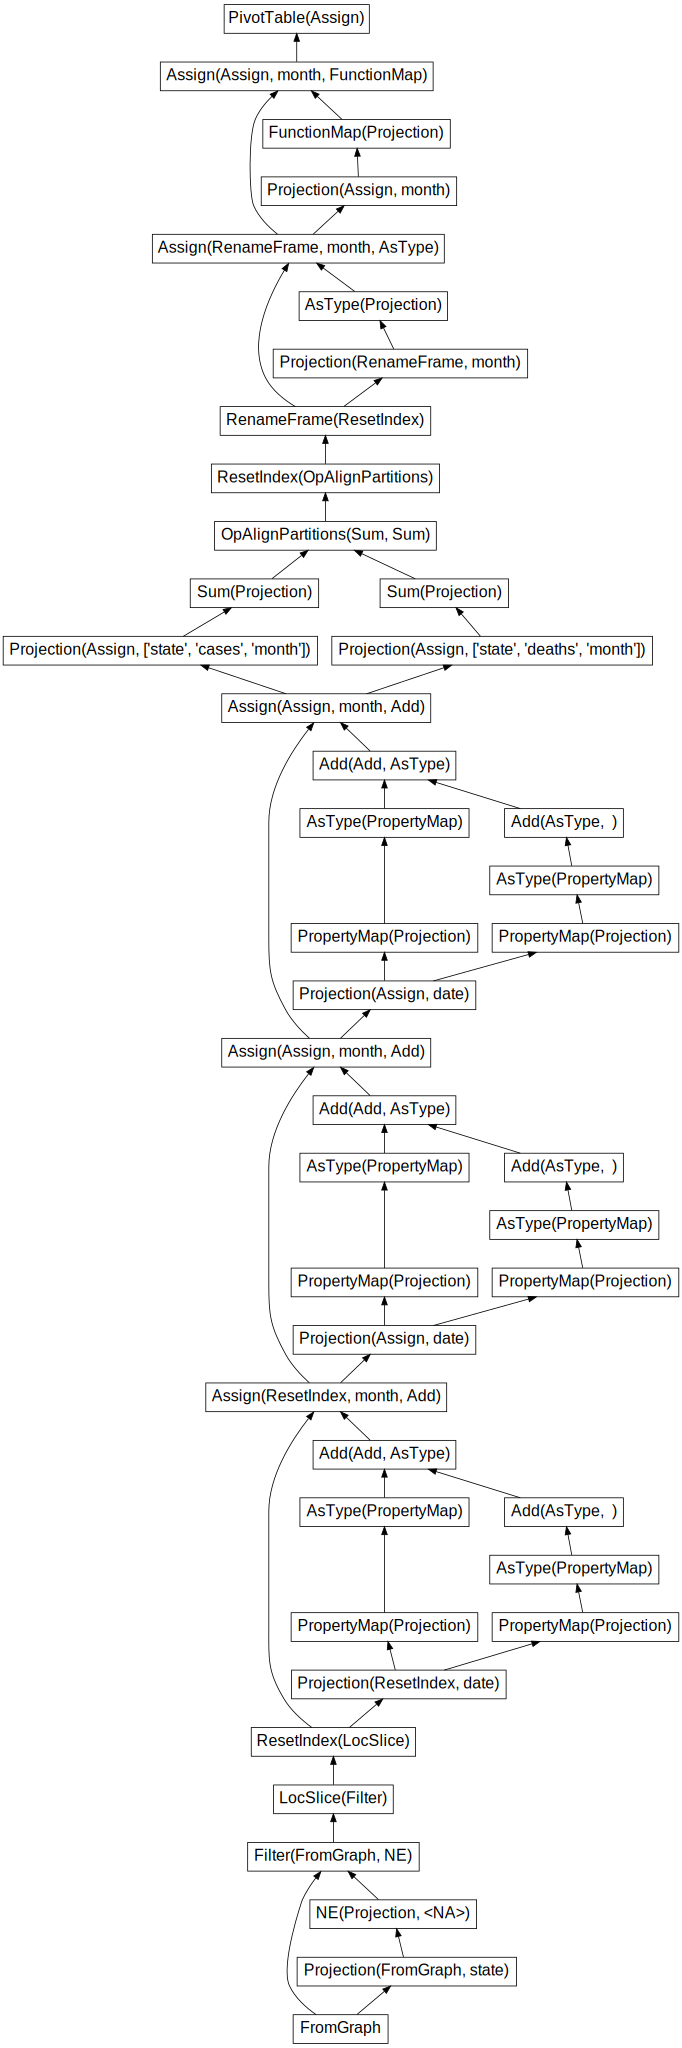

In [42]:
#visualize graph of CFR function
cfr_ddf = compute_cfr(filtered_df)
cfr_ddf.visualize(filename='cfr_graph.png')

In [43]:
#time and compute CFR
#%%timeit
result = compute_cfr(filtered_df)
result.compute()

month,1 2020,2 2020,3 2020,4 2020,5 2020,6 2020,7 2020
state,,,,,,,
Alabama,NaN,NaN,0.005323,0.028309,0.038893,0.029629,0.023818
Alaska,NaN,NaN,0.003350,0.023145,0.021969,0.013032,0.012074
American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arizona,0.0,0.000000,0.000000,0.014865,0.019922,0.002115,0.009735
Arkansas,NaN,NaN,0.009157,0.019115,0.021296,0.015152,0.012744
California,0.0,0.000000,0.020067,0.034800,0.039834,0.031787,0.025430
Colorado,NaN,NaN,0.009393,0.026366,0.053720,0.054192,0.050637
Connecticut,NaN,NaN,0.018148,0.064776,0.090162,0.093831,0.095008
Delaware,NaN,NaN,0.013341,0.027340,0.035748,0.041647,0.040131


###Reasoning
Here, I am grouping data by both state and month and then pivot the data. These operations (groupby, sum, division) are well supported in a distributed context, as each group can be computed in parallel.

##QUESTION 3.4

In [45]:
#function to compute ranking of net month-by-month CFR changes
def compute_ranking(cfr_ddf):
  #I am setting state as index so all calculations are applied row-wise
  rank_df = cfr_ddf.set_index('state')

  #Now calculate difference month-by-month
  month_diff = rank_df.diff(axis=1)

  #net change over the time period
  rank_df['CFR_net_change'] = month_diff.sum(axis=1)

  #ranking the states
  ranking_net = rank_df.sort_values(by='CFR_net_change', ascending=False)

  return ranking_net

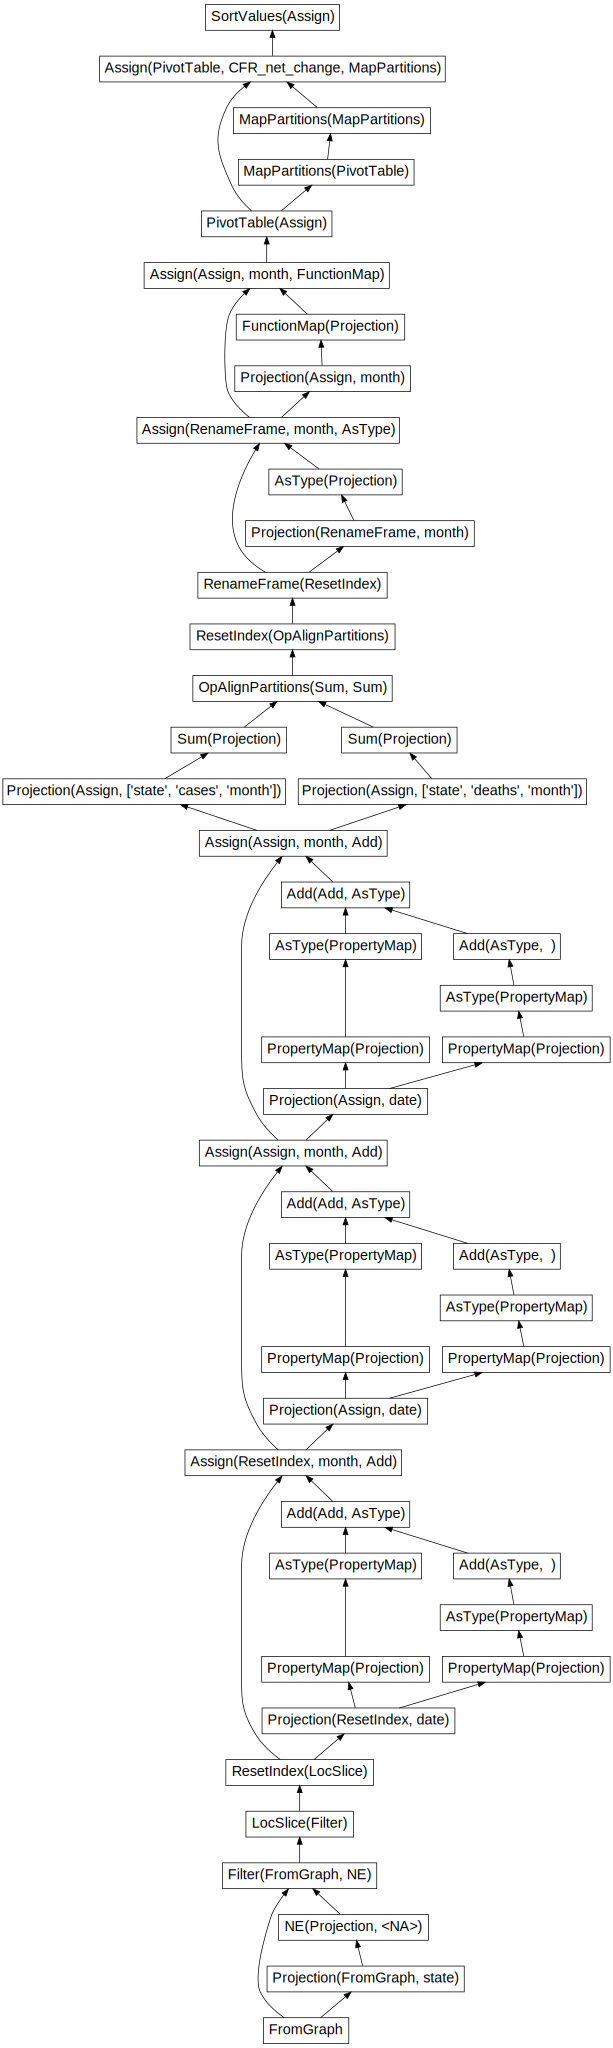

In [46]:
#graph and visualize  the ranking function
rank_ddf = compute_ranking(cfr_ddf)
rank_ddf.visualize(filename='rank_graph.png')

In [47]:
#time and compute rankings
#%%timeit
result = compute_ranking(cfr_ddf)
result.compute()

month,1 2020,2 2020,3 2020,4 2020,5 2020,6 2020,7 2020,CFR_net_change
state,,,,,,,,
New Jersey,NaN,NaN,0.004017,0.040650,0.069340,0.077737,0.082514,0.074479
Massachusetts,NaN,0.000000,0.004995,0.044153,0.066257,0.072474,0.074380,0.074380
New Hampshire,NaN,NaN,0.002688,0.015470,0.040250,0.059926,0.064367,0.058992
Connecticut,NaN,NaN,0.018148,0.064776,0.090162,0.093831,0.095008,0.058713
Rhode Island,NaN,NaN,0.000617,0.015165,0.033145,0.054761,0.058213,0.056979
Pennsylvania,NaN,NaN,0.010814,0.032923,0.068352,0.075062,0.074190,0.052561
Illinois,0.0,0.000000,0.012882,0.040484,0.044274,0.047601,0.048028,0.048028
Maryland,NaN,NaN,0.002610,0.036844,0.048061,0.046710,0.046493,0.041273
Minnesota,NaN,NaN,0.000000,0.025276,0.030523,0.041732,0.039581,0.039581


###REASONING
in problem 3.4, I have chosen to assume that NaN values are missing data, and so I have not filled with zeros before calculating net change.

After pivoting, I compute month-to-month differences and aggregate these changes to get a net change value. Although the resulting matrix (states by months) may be small compared to the raw dataset, keeping the operation in Dask allows me to maintain a consistent distributed workflow.